In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from sklearn.metrics import mean_absolute_error

#This section of code has all of the data import, merging, and initial setup.

test_data_split = 231  #this will be the number of weeks in the test data set, remainder of data in train data set
#Calculate the split date to use
split_date = datetime.now() - timedelta(weeks=test_data_split) 
print('Split Date: {0}'.format(split_date))

#Read in the transportation data, monthly seasonally adjusted
tsi_data = pd.read_excel(".\data\Input_SeasonalData_TSI.xlsx", header=2)

#Read in the real gdp growth rates,seasonally adjusted, quarterly data with quarterly growth rates
gdp_data = pd.read_excel(".\data\Input_GDP_st_louis_fed_quarterly_change.xlsx")

#Merge the 2 datasets together based on the date. 
merged_data = pd.merge(tsi_data, gdp_data, how='left', left_on='OBS_DATE', right_on='observation_date')

#We now have 2 date columns.  Drop the date column from the gdp_data dataframe.
merged_data = merged_data.drop(['observation_date'], axis=1) #pandas can drop rows or columns, axis=1 indicates columns

#Forward fill the gdp data so that a quarterly gdp value will be used for 3 rows, with each row being a month.
#limit it only fill in 2 consective missing values.
merged_data['Real_gdp_qtr_growth'] = merged_data['Real_gdp_qtr_growth'].fillna(method='ffill', limit=2)

#drop rows where we don't have a gdp value
merged_data = merged_data.dropna(subset=['Real_gdp_qtr_growth'])

#Create a boolean column to indicate if gdp growth was positive or negative.
merged_data['gdp_is_increasing'] = merged_data.apply(lambda x: True if x['Real_gdp_qtr_growth'] > 0.0 else False, axis=1)

merged_data['RAIL_FRT_PCT'] = merged_data['RAIL_FRT_CARLOADS_D11'].pct_change()*100.0
merged_data['RAIL_INTERMOD_PCT'] = merged_data['RAIL_FRT_INTERMODAL_D11'].pct_change()*100.0
merged_data['WATERBORNE_PCT'] = merged_data['WATERBORNE_D11'].pct_change()*100.0
merged_data['TRUCK_PCT'] = merged_data['TRUCK_D11'].pct_change()*100.0
merged_data['AIR_RTMFM_PCT'] = merged_data['AIR_RTMFM_D11'].pct_change()*100.0
merged_data['TSI_PCT'] = merged_data['TSI'].pct_change()*100.0

#create x_train and y_train dataframes
x_train = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'RAIL_FRT_PCT':'TSI_PCT']
x_train.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_class = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'gdp_is_increasing'] #ydata for classifier models
y_train_class.drop([0], inplace=True) #drop first row as it will have NA for pct_change values
y_train_rate = merged_data.loc[merged_data['OBS_DATE'] < split_date, 'Real_gdp_qtr_growth'] #y data for regression models
y_train_rate.drop([0], inplace=True) #drop first row as it will have NA for pct_change values

print('x_train row count: {0}'.format(len(x_train.index)))
print('y_train_class row count: {0}'.format(len(y_train_class.index)))
print('y_train_rate row count: {0}'.format(len(y_train_rate.index)))

x_test = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'RAIL_FRT_PCT':'TSI_PCT']
y_test_class = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'gdp_is_increasing']
y_test_rate = merged_data.loc[merged_data['OBS_DATE'] >= split_date, 'Real_gdp_qtr_growth']

print('x_test row count: {0}'.format(len(x_test.index)))
print('y_test_class row count: {0}'.format(len(y_test_class.index)))
print('y_test_rate row count: {0}'.format(len(y_test_rate.index)))

Split Date: 2015-11-25 19:45:51.080214
x_train row count: 190
y_train_class row count: 190
y_train_rate row count: 190
x_test row count: 49
y_test_class row count: 49
y_test_rate row count: 49


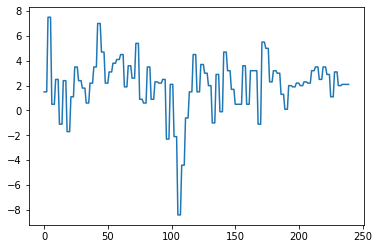

In [2]:
import matplotlib.pyplot as plt

plt.plot(merged_data['Real_gdp_qtr_growth'])

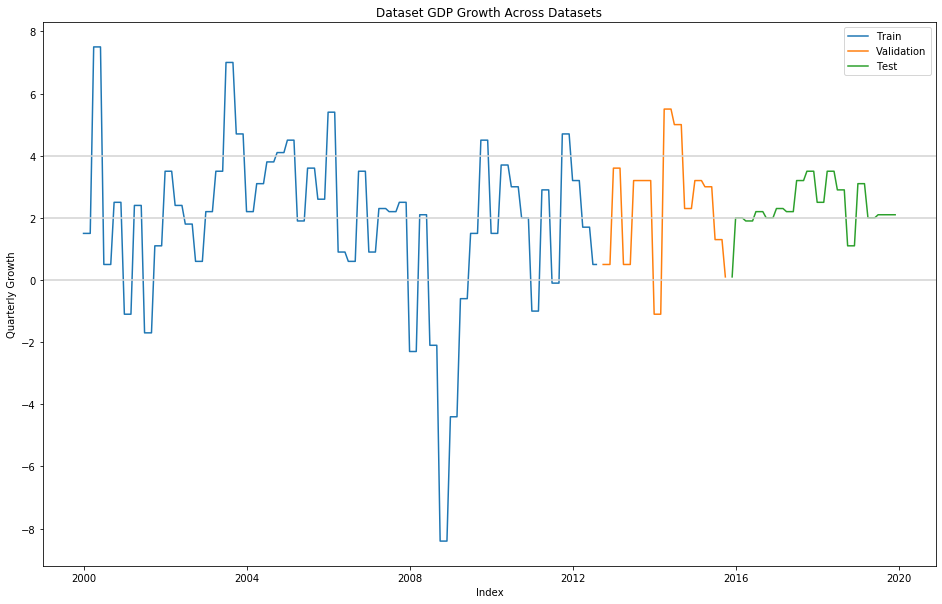

In [58]:
plt.plot(merged_data.iloc[:152]['OBS_DATE'], merged_data.iloc[:152]['Real_gdp_qtr_growth'], Label="Train")
plt.plot(merged_data.iloc[153:190]['OBS_DATE'], merged_data.iloc[153:190]['Real_gdp_qtr_growth'], Label="Validation")
plt.plot(merged_data.iloc[191:]['OBS_DATE'], merged_data.iloc[191:]['Real_gdp_qtr_growth'], Label="Test")
plt.title('Dataset GDP Growth Across Datasets')
plt.ylabel('Quarterly Growth')
plt.xlabel('Index')
#plt.xticks(np.arange(2000, 2020,step=2))
plt.legend()
plt.axhline(0, 0, 250, c='lightgrey')
plt.axhline(2, 0, 250, c='lightgrey')
plt.axhline(4, 0, 250, c='lightgrey')
fig = plt.gcf()
fig.set_size_inches(16,10)
#merged_data

In [4]:
y_train_std = merged_data.iloc[:152]['Real_gdp_qtr_growth'].std(axis=0)
print('y_train_std: {0:0.2f}'.format(y_train_std))

y_val_std = merged_data.iloc[153:190]['Real_gdp_qtr_growth'].std(axis=0)
print('y_val_std: {0:0.2f}'.format(y_val_std))

y_test_std = merged_data.iloc[191:]['Real_gdp_qtr_growth'].std(axis=0)
print('y_test_std: {0:0.2f}'.format(y_test_std))


y_train_std: 2.67
y_val_std: 1.88
y_test_std: 0.72


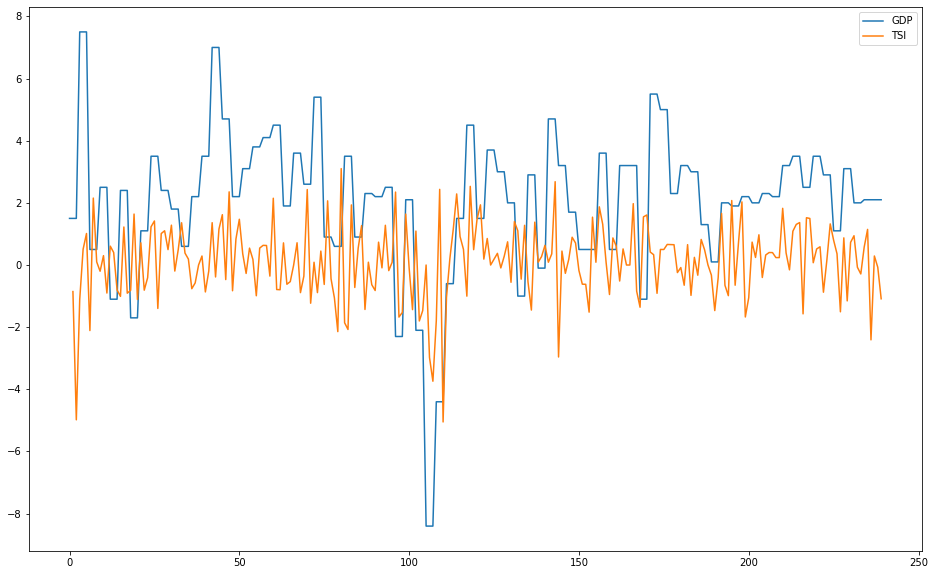

In [57]:
from matplotlib.pyplot import figure
#plt.plot(merged_data['RAIL_FRT_PCT'], label='Rail Frt')
plt.plot(merged_data['Real_gdp_qtr_growth'], label='GDP')
#plt.plot(merged_data['RAIL_INTERMOD_PCT'], label='Rail Intermod')
#plt.plot(merged_data['WATERBORNE_PCT'], label='Water')
#plt.plot(merged_data['TRUCK_PCT'], label='Truck')
#plt.plot(merged_data['AIR_RTMFM_PCT'], label='Air and Mail Frt')
plt.plot(merged_data['TSI_PCT'], label='TSI')
plt.legend()
fig = plt.gcf()
fig.set_size_inches(16,10)

In [5]:
railcorr = np.corrcoef(x_train['RAIL_FRT_PCT'], y_train_rate)
print('Rail Frt Corr: {0:0.2f}'.format(railcorr[0,1]))

railimodcorr = np.corrcoef(x_train['RAIL_INTERMOD_PCT'], y_train_rate)
print('Rail Intermod Corr: {0:0.2f}'.format(railimodcorr[0,1]))

watercorr = np.corrcoef(x_train['WATERBORNE_PCT'], y_train_rate)
print('Water Corr: {0:0.2f}'.format(watercorr[0,1]))

truckcorr = np.corrcoef(x_train['TRUCK_PCT'], y_train_rate)
print('Truck Corr: {0:0.2f}'.format(truckcorr[0,1]))

aircorr = np.corrcoef(x_train['AIR_RTMFM_PCT'], y_train_rate)
print('Air and Mail Frt Corr: {0:0.2f}'.format(aircorr[0,1]))

tsicorr = np.corrcoef(x_train['TSI_PCT'], y_train_rate)
print('TSI Corr: {0:0.2f}'.format(tsicorr[0,1]))


Rail Frt Corr: 0.13
Rail Intermod Corr: 0.21
Water Corr: 0.02
Truck Corr: 0.18
Air and Mail Frt Corr: 0.19
TSI Corr: 0.23


In [6]:
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train_std = x_train - mean
x_train_std = x_train / std

x_test_std = x_test - mean
x_test_std = x_test / std

In [7]:
#x_train_std.shape[1,]
x_trainstdnp = x_train_std.to_numpy()
x_trainstdnp.shape

(190, 6)

In [147]:
from keras.models import Sequential
from keras.layers import Dense , Lambda #,Dropout ,  Flatten
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
#import tensorflow as tf

def get_nn_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(1,)),
        BatchNormalization(),
        Dense(16, activation='relu'),
        BatchNormalization(),
        Dense(1)
    ])
    model.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model        

In [151]:
model=get_nn_model()
model.optimizer.lr=0.001
#history=model.fit(x=x_train_std.iloc[:153]['TSI_PCT'], y=y_train_rate.iloc[:153], epochs=500)#, validation_split=0.2) # shuffle=True) #, batch_size=5)
history=model.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2) # shuffle=True) #, batch_size=5)

Train on 152 samples, validate on 38 samples
Epoch 1/500
152/152 [==============================] - 4s 24ms/step - loss: 12.2249 - mean_absolute_error: 2.9163 - val_loss: 12.4585 - val_mean_absolute_error: 3.0280
Epoch 2/500
152/152 [==============================] - 0s 105us/step - loss: 11.5730 - mean_absolute_error: 2.8326 - val_loss: 11.5454 - val_mean_absolute_error: 2.9008
Epoch 3/500
152/152 [==============================] - 0s 105us/step - loss: 11.3607 - mean_absolute_error: 2.8211 - val_loss: 10.5790 - val_mean_absolute_error: 2.7592
Epoch 4/500
152/152 [==============================] - 0s 118us/step - loss: 10.5779 - mean_absolute_error: 2.7024 - val_loss: 9.4344 - val_mean_absolute_error: 2.5887
Epoch 5/500
152/152 [==============================] - 0s 112us/step - loss: 10.0880 - mean_absolute_error: 2.6617 - val_loss: 8.4125 - val_mean_absolute_error: 2.4433
Epoch 6/500
152/152 [==============================] - 0s 112us/step - loss: 9.5745 - mean_absolute_error: 2.5656

152/152 [==============================] - 0s 257us/step - loss: 6.2909 - mean_absolute_error: 1.9274 - val_loss: 3.7147 - val_mean_absolute_error: 1.6609
Epoch 50/500
152/152 [==============================] - ETA: 0s - loss: 6.0172 - mean_absolute_error: 1.828 - 0s 92us/step - loss: 6.2176 - mean_absolute_error: 1.8974 - val_loss: 3.6422 - val_mean_absolute_error: 1.6456
Epoch 51/500
152/152 [==============================] - 0s 158us/step - loss: 6.0652 - mean_absolute_error: 1.8846 - val_loss: 3.5980 - val_mean_absolute_error: 1.6363
Epoch 52/500
152/152 [==============================] - 0s 105us/step - loss: 6.0493 - mean_absolute_error: 1.8834 - val_loss: 3.6161 - val_mean_absolute_error: 1.6403
Epoch 53/500
152/152 [==============================] - ETA: 0s - loss: 8.7596 - mean_absolute_error: 2.149 - 0s 105us/step - loss: 6.0354 - mean_absolute_error: 1.8814 - val_loss: 3.6366 - val_mean_absolute_error: 1.6460
Epoch 54/500
152/152 [==============================] - 0s 105us/s

152/152 [==============================] - 0s 118us/step - loss: 5.9519 - mean_absolute_error: 1.8035 - val_loss: 3.3670 - val_mean_absolute_error: 1.5744
Epoch 98/500
152/152 [==============================] - 0s 99us/step - loss: 6.0515 - mean_absolute_error: 1.8664 - val_loss: 3.3440 - val_mean_absolute_error: 1.5729
Epoch 99/500
152/152 [==============================] - 0s 118us/step - loss: 5.8993 - mean_absolute_error: 1.8154 - val_loss: 3.3225 - val_mean_absolute_error: 1.5685
Epoch 100/500
152/152 [==============================] - 0s 112us/step - loss: 5.8980 - mean_absolute_error: 1.8472 - val_loss: 3.2326 - val_mean_absolute_error: 1.5560
Epoch 101/500
152/152 [==============================] - 0s 105us/step - loss: 5.7844 - mean_absolute_error: 1.7892 - val_loss: 3.3043 - val_mean_absolute_error: 1.5684
Epoch 102/500
152/152 [==============================] - 0s 112us/step - loss: 5.9160 - mean_absolute_error: 1.8085 - val_loss: 3.3437 - val_mean_absolute_error: 1.5780
Epo

152/152 [==============================] - 0s 112us/step - loss: 5.9929 - mean_absolute_error: 1.8308 - val_loss: 3.2360 - val_mean_absolute_error: 1.5470
Epoch 146/500
152/152 [==============================] - 0s 112us/step - loss: 6.0787 - mean_absolute_error: 1.8244 - val_loss: 3.2222 - val_mean_absolute_error: 1.5467
Epoch 147/500
152/152 [==============================] - 0s 112us/step - loss: 5.9146 - mean_absolute_error: 1.8110 - val_loss: 3.2304 - val_mean_absolute_error: 1.5466
Epoch 148/500
152/152 [==============================] - 0s 118us/step - loss: 6.2099 - mean_absolute_error: 1.8662 - val_loss: 3.2183 - val_mean_absolute_error: 1.5451
Epoch 149/500
152/152 [==============================] - 0s 125us/step - loss: 5.8440 - mean_absolute_error: 1.7818 - val_loss: 3.2753 - val_mean_absolute_error: 1.5497
Epoch 150/500
152/152 [==============================] - 0s 112us/step - loss: 6.1156 - mean_absolute_error: 1.8309 - val_loss: 3.3699 - val_mean_absolute_error: 1.5777


152/152 [==============================] - 0s 118us/step - loss: 5.8494 - mean_absolute_error: 1.8134 - val_loss: 3.0524 - val_mean_absolute_error: 1.4861
Epoch 194/500
152/152 [==============================] - 0s 112us/step - loss: 6.0859 - mean_absolute_error: 1.8394 - val_loss: 3.0030 - val_mean_absolute_error: 1.4796
Epoch 195/500
152/152 [==============================] - 0s 118us/step - loss: 5.7537 - mean_absolute_error: 1.7862 - val_loss: 3.0955 - val_mean_absolute_error: 1.5133
Epoch 196/500
152/152 [==============================] - 0s 112us/step - loss: 5.8717 - mean_absolute_error: 1.7744 - val_loss: 3.0752 - val_mean_absolute_error: 1.5136
Epoch 197/500
152/152 [==============================] - 0s 105us/step - loss: 5.9501 - mean_absolute_error: 1.8061 - val_loss: 3.0601 - val_mean_absolute_error: 1.5112
Epoch 198/500
152/152 [==============================] - 0s 112us/step - loss: 5.7641 - mean_absolute_error: 1.7953 - val_loss: 3.1358 - val_mean_absolute_error: 1.5312


152/152 [==============================] - 0s 105us/step - loss: 5.9603 - mean_absolute_error: 1.8371 - val_loss: 3.5226 - val_mean_absolute_error: 1.6011
Epoch 242/500
152/152 [==============================] - 0s 118us/step - loss: 6.0139 - mean_absolute_error: 1.8279 - val_loss: 3.5748 - val_mean_absolute_error: 1.6145
Epoch 243/500
152/152 [==============================] - 0s 112us/step - loss: 5.8271 - mean_absolute_error: 1.7880 - val_loss: 3.5034 - val_mean_absolute_error: 1.6053
Epoch 244/500
152/152 [==============================] - 0s 118us/step - loss: 6.0793 - mean_absolute_error: 1.8061 - val_loss: 3.2086 - val_mean_absolute_error: 1.5451
Epoch 245/500
152/152 [==============================] - 0s 112us/step - loss: 5.8269 - mean_absolute_error: 1.7848 - val_loss: 3.0279 - val_mean_absolute_error: 1.4865
Epoch 246/500
152/152 [==============================] - 0s 112us/step - loss: 5.9204 - mean_absolute_error: 1.7895 - val_loss: 3.0745 - val_mean_absolute_error: 1.5030


152/152 [==============================] - 0s 105us/step - loss: 5.7228 - mean_absolute_error: 1.7842 - val_loss: 3.7451 - val_mean_absolute_error: 1.6501
Epoch 290/500
152/152 [==============================] - 0s 105us/step - loss: 5.8110 - mean_absolute_error: 1.8054 - val_loss: 3.7187 - val_mean_absolute_error: 1.6572
Epoch 291/500
152/152 [==============================] - 0s 99us/step - loss: 6.0566 - mean_absolute_error: 1.8154 - val_loss: 3.5349 - val_mean_absolute_error: 1.5941
Epoch 292/500
152/152 [==============================] - 0s 99us/step - loss: 5.7854 - mean_absolute_error: 1.7817 - val_loss: 3.2355 - val_mean_absolute_error: 1.5240
Epoch 293/500
152/152 [==============================] - 0s 112us/step - loss: 5.7254 - mean_absolute_error: 1.7639 - val_loss: 3.1324 - val_mean_absolute_error: 1.5055
Epoch 294/500
152/152 [==============================] - 0s 112us/step - loss: 6.1177 - mean_absolute_error: 1.8525 - val_loss: 3.1250 - val_mean_absolute_error: 1.5037
Ep

152/152 [==============================] - 0s 118us/step - loss: 6.2273 - mean_absolute_error: 1.8511 - val_loss: 3.2854 - val_mean_absolute_error: 1.5522
Epoch 338/500
152/152 [==============================] - 0s 99us/step - loss: 5.9306 - mean_absolute_error: 1.8122 - val_loss: 3.3312 - val_mean_absolute_error: 1.5770
Epoch 339/500
152/152 [==============================] - 0s 112us/step - loss: 5.8342 - mean_absolute_error: 1.7937 - val_loss: 3.3339 - val_mean_absolute_error: 1.5687
Epoch 340/500
152/152 [==============================] - 0s 105us/step - loss: 5.7407 - mean_absolute_error: 1.7841 - val_loss: 3.3661 - val_mean_absolute_error: 1.5670
Epoch 341/500
152/152 [==============================] - 0s 105us/step - loss: 5.8671 - mean_absolute_error: 1.8041 - val_loss: 3.3866 - val_mean_absolute_error: 1.5784
Epoch 342/500
152/152 [==============================] - 0s 112us/step - loss: 6.0090 - mean_absolute_error: 1.8084 - val_loss: 3.3874 - val_mean_absolute_error: 1.5718
E

152/152 [==============================] - 0s 125us/step - loss: 5.9833 - mean_absolute_error: 1.8053 - val_loss: 3.1229 - val_mean_absolute_error: 1.5166
Epoch 386/500
152/152 [==============================] - 0s 125us/step - loss: 6.0270 - mean_absolute_error: 1.8367 - val_loss: 3.3888 - val_mean_absolute_error: 1.5859
Epoch 387/500
152/152 [==============================] - 0s 118us/step - loss: 5.9189 - mean_absolute_error: 1.8109 - val_loss: 3.2973 - val_mean_absolute_error: 1.5499
Epoch 388/500
152/152 [==============================] - 0s 125us/step - loss: 5.7240 - mean_absolute_error: 1.7716 - val_loss: 3.1987 - val_mean_absolute_error: 1.5342
Epoch 389/500
152/152 [==============================] - 0s 118us/step - loss: 6.0838 - mean_absolute_error: 1.8246 - val_loss: 3.1876 - val_mean_absolute_error: 1.5362
Epoch 390/500
152/152 [==============================] - 0s 118us/step - loss: 5.8132 - mean_absolute_error: 1.7954 - val_loss: 3.2787 - val_mean_absolute_error: 1.5372


152/152 [==============================] - 0s 118us/step - loss: 5.9014 - mean_absolute_error: 1.7825 - val_loss: 3.5562 - val_mean_absolute_error: 1.5746
Epoch 434/500
152/152 [==============================] - 0s 105us/step - loss: 5.8174 - mean_absolute_error: 1.7595 - val_loss: 3.6227 - val_mean_absolute_error: 1.5783
Epoch 435/500
152/152 [==============================] - 0s 112us/step - loss: 6.1018 - mean_absolute_error: 1.7908 - val_loss: 3.5456 - val_mean_absolute_error: 1.5711
Epoch 436/500
152/152 [==============================] - 0s 99us/step - loss: 5.7746 - mean_absolute_error: 1.7841 - val_loss: 3.4407 - val_mean_absolute_error: 1.5561
Epoch 437/500
152/152 [==============================] - 0s 112us/step - loss: 6.0723 - mean_absolute_error: 1.8047 - val_loss: 3.3199 - val_mean_absolute_error: 1.5379
Epoch 438/500
152/152 [==============================] - 0s 105us/step - loss: 5.9375 - mean_absolute_error: 1.7891 - val_loss: 3.3093 - val_mean_absolute_error: 1.5468
E

152/152 [==============================] - 0s 119us/step - loss: 6.1216 - mean_absolute_error: 1.8325 - val_loss: 3.3040 - val_mean_absolute_error: 1.5468
Epoch 482/500
152/152 [==============================] - 0s 112us/step - loss: 5.9505 - mean_absolute_error: 1.8128 - val_loss: 3.2096 - val_mean_absolute_error: 1.5393
Epoch 483/500
152/152 [==============================] - 0s 118us/step - loss: 6.0809 - mean_absolute_error: 1.8499 - val_loss: 3.3119 - val_mean_absolute_error: 1.5634
Epoch 484/500
152/152 [==============================] - 0s 112us/step - loss: 5.9019 - mean_absolute_error: 1.7919 - val_loss: 3.3074 - val_mean_absolute_error: 1.5549
Epoch 485/500
152/152 [==============================] - 0s 112us/step - loss: 6.0218 - mean_absolute_error: 1.8248 - val_loss: 3.3476 - val_mean_absolute_error: 1.5563
Epoch 486/500
152/152 [==============================] - 0s 105us/step - loss: 5.8433 - mean_absolute_error: 1.7783 - val_loss: 3.3769 - val_mean_absolute_error: 1.5508


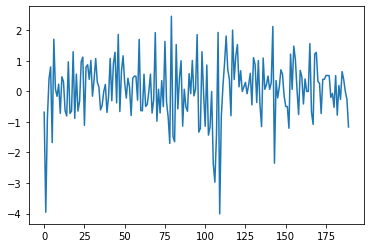

In [56]:
#x_train
plt.plot(x_train_std['TSI_PCT'].to_numpy(), Label="x_train")

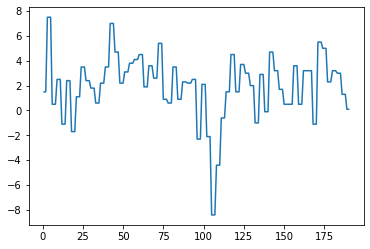

In [291]:
plt.plot(y_train_rate, Label="y_train_rate")

In [152]:
predictions_test = model.predict(x_test_std['TSI_PCT'])

test_mean_abs_error = mean_absolute_error(y_test_rate, predictions_test)
print('Test mean abs error: {0:0.2f}'.format(test_mean_abs_error))

Test mean abs error: 0.71


In [38]:
predictions_test.transpose()

array([[2.3952944, 2.2980156, 2.3056765, 2.221819 , 2.2199662, 2.306345 ,
        2.4611363, 2.2282085, 2.049066 , 2.2050457, 2.4611363, 2.4611363,
        2.4272966, 2.3995044, 2.4611363, 2.4611363, 2.4611363, 2.4611363,
        2.4611363, 2.26713  , 2.4611363, 2.4611363, 2.4055986, 2.3644264,
        2.3533251, 2.0742805, 2.3241308, 2.3284168, 2.4611363, 2.4611363,
        2.4611363, 2.249713 , 2.4611363, 2.3614414, 2.4601703, 2.4611363,
        2.0910234, 2.4459343, 2.1794155, 2.4611363, 2.4330182, 2.4611363,
        2.4396772, 2.4611363, 2.3946269, 1.8637171, 2.4611363, 2.4611363,
        2.1965995]], dtype=float32)

In [16]:
y_test_rate.to_numpy()

array([0.1, 2. , 2. , 2. , 1.9, 1.9, 1.9, 2.2, 2.2, 2.2, 2. , 2. , 2. ,
       2.3, 2.3, 2.3, 2.2, 2.2, 2.2, 3.2, 3.2, 3.2, 3.5, 3.5, 3.5, 2.5,
       2.5, 2.5, 3.5, 3.5, 3.5, 2.9, 2.9, 2.9, 1.1, 1.1, 1.1, 3.1, 3.1,
       3.1, 2. , 2. , 2. , 2.1, 2.1, 2.1, 2.1, 2.1, 2.1])

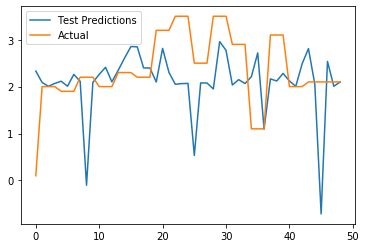

In [115]:
plt.plot(predictions_test, label='Test Predictions')
plt.plot(y_test_rate.index - 191, y_test_rate, label='Actual') #the dataframe has its index from the data split
plt.legend()

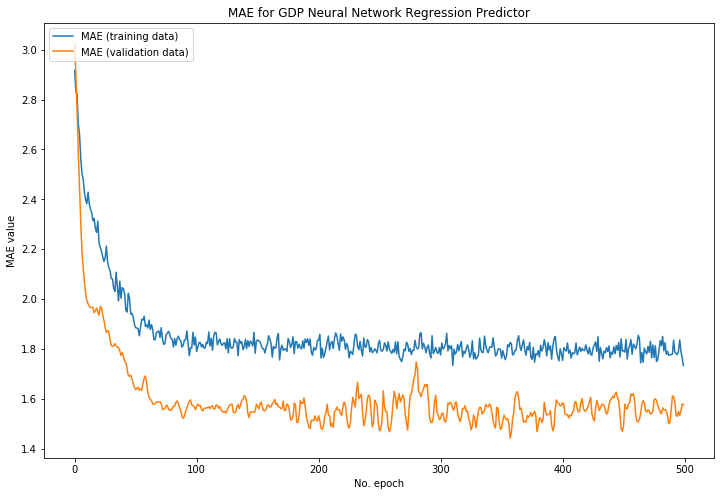

In [253]:
# Plot history: MAE
plt.plot(history.history['mean_absolute_error'], label='MAE (training data)')
plt.plot(history.history['val_mean_absolute_error'], label='MAE (validation data)')
plt.title('MAE for GDP Neural Network Regression Predictor')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [ ]:
# Plot history: MSE
plt.plot(history.history['loss'], label='MSE (training data)')
plt.plot(history.history['val_loss'], label='MSE (validation data)')
plt.title('MSE for GDP Neural Network Regression Predictor')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [319]:
from keras import regularizers
from keras import models
from keras import layers

def get_nn_model_regularization(penalty, reg_type="L2", dense_layers=16):
    model_regn = models.Sequential()
    
    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l1(penalty)))
        
    #model_regn.add(layers.BatchNormalization())

    if reg_type == "L2":
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l2(penalty)))
    else:
        model_regn.add(layers.Dense(dense_layers, activation='relu', input_shape=(1,), kernel_regularizer=regularizers.l1(penalty)))

    #model_regn.add(layers.BatchNormalization())
    model_regn.add(layers.Dense(1, activation='linear'))
    
    model_regn.compile(optimizer='Adam', loss='mse', metrics=['mae'])
    return model_regn 

In [264]:
model_reg = get_nn_model_regularization(0.1)
model_reg.optimizer.lr = 0.0006 #0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2)

Train on 152 samples, validate on 38 samples
Epoch 1/500
152/152 [==============================] - 39s 256ms/step - loss: 11.9977 - mean_absolute_error: 2.6321 - val_loss: 10.0175 - val_mean_absolute_error: 2.3865
Epoch 2/500
152/152 [==============================] - 0s 592us/step - loss: 11.9854 - mean_absolute_error: 2.6270 - val_loss: 9.7933 - val_mean_absolute_error: 2.3574
Epoch 3/500
152/152 [==============================] - 0s 539us/step - loss: 11.7377 - mean_absolute_error: 2.6226 - val_loss: 9.5880 - val_mean_absolute_error: 2.3319
Epoch 4/500
152/152 [==============================] - 0s 612us/step - loss: 11.5007 - mean_absolute_error: 2.5890 - val_loss: 9.4708 - val_mean_absolute_error: 2.3188
Epoch 5/500
152/152 [==============================] - 0s 605us/step - loss: 11.2151 - mean_absolute_error: 2.5234 - val_loss: 9.2744 - val_mean_absolute_error: 2.2885
Epoch 6/500
152/152 [==============================] - 0s 559us/step - loss: 11.1603 - mean_absolute_error: 2.545

152/152 [==============================] - 0s 559us/step - loss: 8.7946 - mean_absolute_error: 2.1907 - val_loss: 6.2395 - val_mean_absolute_error: 1.9343
Epoch 50/500
152/152 [==============================] - 0s 586us/step - loss: 8.2876 - mean_absolute_error: 2.1140 - val_loss: 6.2321 - val_mean_absolute_error: 1.9329
Epoch 51/500
152/152 [==============================] - ETA: 0s - loss: 7.6722 - mean_absolute_error: 2.027 - 0s 500us/step - loss: 8.2772 - mean_absolute_error: 2.1027 - val_loss: 6.1963 - val_mean_absolute_error: 1.9262
Epoch 52/500
152/152 [==============================] - 0s 500us/step - loss: 8.3089 - mean_absolute_error: 2.0677 - val_loss: 6.1159 - val_mean_absolute_error: 1.9122
Epoch 53/500
152/152 [==============================] - 0s 507us/step - loss: 8.2467 - mean_absolute_error: 2.1131 - val_loss: 5.9551 - val_mean_absolute_error: 1.8883
Epoch 54/500
152/152 [==============================] - 0s 520us/step - loss: 8.4607 - mean_absolute_error: 2.1135 - va

152/152 [==============================] - 0s 579us/step - loss: 6.8775 - mean_absolute_error: 1.8744 - val_loss: 4.7962 - val_mean_absolute_error: 1.7307
Epoch 98/500
152/152 [==============================] - 0s 493us/step - loss: 7.0367 - mean_absolute_error: 1.8812 - val_loss: 4.8893 - val_mean_absolute_error: 1.7476
Epoch 99/500
152/152 [==============================] - 0s 566us/step - loss: 7.2012 - mean_absolute_error: 1.9098 - val_loss: 4.8962 - val_mean_absolute_error: 1.7505
Epoch 100/500
152/152 [==============================] - 0s 500us/step - loss: 6.8971 - mean_absolute_error: 1.8981 - val_loss: 4.9414 - val_mean_absolute_error: 1.7601
Epoch 101/500
152/152 [==============================] - 0s 513us/step - loss: 7.2340 - mean_absolute_error: 1.9123 - val_loss: 5.0122 - val_mean_absolute_error: 1.7735
Epoch 102/500
152/152 [==============================] - 0s 526us/step - loss: 6.9276 - mean_absolute_error: 1.8739 - val_loss: 5.0997 - val_mean_absolute_error: 1.7890
Ep

152/152 [==============================] - 0s 520us/step - loss: 6.6107 - mean_absolute_error: 1.8051 - val_loss: 4.2408 - val_mean_absolute_error: 1.6195
Epoch 146/500
152/152 [==============================] - 0s 513us/step - loss: 6.7348 - mean_absolute_error: 1.8271 - val_loss: 4.3203 - val_mean_absolute_error: 1.6386
Epoch 147/500
152/152 [==============================] - 0s 566us/step - loss: 6.6341 - mean_absolute_error: 1.8278 - val_loss: 4.2995 - val_mean_absolute_error: 1.6314
Epoch 148/500
152/152 [==============================] - 0s 586us/step - loss: 6.6819 - mean_absolute_error: 1.8405 - val_loss: 4.2713 - val_mean_absolute_error: 1.6200
Epoch 149/500
152/152 [==============================] - 0s 513us/step - loss: 6.6531 - mean_absolute_error: 1.8214 - val_loss: 4.2672 - val_mean_absolute_error: 1.6267
Epoch 150/500
152/152 [==============================] - 0s 493us/step - loss: 6.8672 - mean_absolute_error: 1.8296 - val_loss: 4.2059 - val_mean_absolute_error: 1.6188


152/152 [==============================] - 0s 520us/step - loss: 6.3553 - mean_absolute_error: 1.7825 - val_loss: 3.8608 - val_mean_absolute_error: 1.5533
Epoch 194/500
152/152 [==============================] - 0s 533us/step - loss: 6.5730 - mean_absolute_error: 1.8144 - val_loss: 3.8090 - val_mean_absolute_error: 1.5411
Epoch 195/500
152/152 [==============================] - 0s 520us/step - loss: 6.3180 - mean_absolute_error: 1.7869 - val_loss: 3.8281 - val_mean_absolute_error: 1.5365
Epoch 196/500
152/152 [==============================] - 0s 533us/step - loss: 6.5329 - mean_absolute_error: 1.8010 - val_loss: 3.7727 - val_mean_absolute_error: 1.5252
Epoch 197/500
152/152 [==============================] - 0s 513us/step - loss: 6.8310 - mean_absolute_error: 1.8300 - val_loss: 3.7791 - val_mean_absolute_error: 1.5269
Epoch 198/500
152/152 [==============================] - 0s 513us/step - loss: 6.7132 - mean_absolute_error: 1.8319 - val_loss: 3.7797 - val_mean_absolute_error: 1.5344


152/152 [==============================] - 0s 487us/step - loss: 6.4966 - mean_absolute_error: 1.8093 - val_loss: 4.0701 - val_mean_absolute_error: 1.5978
Epoch 242/500
152/152 [==============================] - 0s 566us/step - loss: 6.5518 - mean_absolute_error: 1.8413 - val_loss: 3.9093 - val_mean_absolute_error: 1.5689
Epoch 243/500
152/152 [==============================] - 0s 559us/step - loss: 6.7013 - mean_absolute_error: 1.8463 - val_loss: 3.8455 - val_mean_absolute_error: 1.5602
Epoch 244/500
152/152 [==============================] - 0s 539us/step - loss: 6.4491 - mean_absolute_error: 1.8234 - val_loss: 3.8315 - val_mean_absolute_error: 1.5586
Epoch 245/500
152/152 [==============================] - 0s 546us/step - loss: 6.3529 - mean_absolute_error: 1.7919 - val_loss: 3.8707 - val_mean_absolute_error: 1.5552
Epoch 246/500
152/152 [==============================] - 0s 520us/step - loss: 6.5822 - mean_absolute_error: 1.8300 - val_loss: 3.8389 - val_mean_absolute_error: 1.5357


152/152 [==============================] - 0s 507us/step - loss: 6.1793 - mean_absolute_error: 1.7941 - val_loss: 3.9846 - val_mean_absolute_error: 1.5184
Epoch 290/500
152/152 [==============================] - 0s 507us/step - loss: 6.4961 - mean_absolute_error: 1.8265 - val_loss: 3.8565 - val_mean_absolute_error: 1.5154
Epoch 291/500
152/152 [==============================] - 0s 520us/step - loss: 6.9030 - mean_absolute_error: 1.8803 - val_loss: 3.6774 - val_mean_absolute_error: 1.5072
Epoch 292/500
152/152 [==============================] - 0s 487us/step - loss: 6.7090 - mean_absolute_error: 1.8504 - val_loss: 3.8601 - val_mean_absolute_error: 1.5524
Epoch 293/500
152/152 [==============================] - 0s 513us/step - loss: 6.5265 - mean_absolute_error: 1.7910 - val_loss: 3.9643 - val_mean_absolute_error: 1.5864
Epoch 294/500
152/152 [==============================] - 0s 605us/step - loss: 6.3509 - mean_absolute_error: 1.7942 - val_loss: 4.0540 - val_mean_absolute_error: 1.6165


152/152 [==============================] - 0s 526us/step - loss: 6.6235 - mean_absolute_error: 1.8424 - val_loss: 4.0353 - val_mean_absolute_error: 1.6230
Epoch 338/500
152/152 [==============================] - 0s 526us/step - loss: 6.3039 - mean_absolute_error: 1.8188 - val_loss: 3.9376 - val_mean_absolute_error: 1.5958
Epoch 339/500
152/152 [==============================] - 0s 513us/step - loss: 6.3451 - mean_absolute_error: 1.8278 - val_loss: 3.8247 - val_mean_absolute_error: 1.5722
Epoch 340/500
152/152 [==============================] - 0s 513us/step - loss: 6.4815 - mean_absolute_error: 1.8366 - val_loss: 3.8303 - val_mean_absolute_error: 1.5760
Epoch 341/500
152/152 [==============================] - 0s 520us/step - loss: 6.6363 - mean_absolute_error: 1.8399 - val_loss: 3.6717 - val_mean_absolute_error: 1.5407
Epoch 342/500
152/152 [==============================] - 0s 526us/step - loss: 6.4845 - mean_absolute_error: 1.8189 - val_loss: 3.7142 - val_mean_absolute_error: 1.5390


152/152 [==============================] - 0s 520us/step - loss: 6.1748 - mean_absolute_error: 1.7879 - val_loss: 3.7068 - val_mean_absolute_error: 1.5330
Epoch 386/500
152/152 [==============================] - 0s 533us/step - loss: 6.3538 - mean_absolute_error: 1.8194 - val_loss: 3.7030 - val_mean_absolute_error: 1.5311
Epoch 387/500
152/152 [==============================] - 0s 513us/step - loss: 6.5026 - mean_absolute_error: 1.8388 - val_loss: 3.7375 - val_mean_absolute_error: 1.5479
Epoch 388/500
152/152 [==============================] - 0s 526us/step - loss: 6.1749 - mean_absolute_error: 1.7984 - val_loss: 3.7483 - val_mean_absolute_error: 1.5577
Epoch 389/500
152/152 [==============================] - 0s 526us/step - loss: 6.6704 - mean_absolute_error: 1.8719 - val_loss: 3.8264 - val_mean_absolute_error: 1.5772
Epoch 390/500
152/152 [==============================] - 0s 513us/step - loss: 6.3793 - mean_absolute_error: 1.8154 - val_loss: 3.7515 - val_mean_absolute_error: 1.5626


152/152 [==============================] - 0s 500us/step - loss: 6.2051 - mean_absolute_error: 1.7977 - val_loss: 3.7281 - val_mean_absolute_error: 1.5482
Epoch 434/500
152/152 [==============================] - 0s 513us/step - loss: 6.4910 - mean_absolute_error: 1.8334 - val_loss: 3.7348 - val_mean_absolute_error: 1.5436
Epoch 435/500
152/152 [==============================] - 0s 487us/step - loss: 6.4650 - mean_absolute_error: 1.8616 - val_loss: 3.6886 - val_mean_absolute_error: 1.5374
Epoch 436/500
152/152 [==============================] - 0s 526us/step - loss: 6.2753 - mean_absolute_error: 1.8408 - val_loss: 3.7375 - val_mean_absolute_error: 1.5387
Epoch 437/500
152/152 [==============================] - 0s 507us/step - loss: 6.3002 - mean_absolute_error: 1.8068 - val_loss: 3.7324 - val_mean_absolute_error: 1.5387
Epoch 438/500
152/152 [==============================] - 0s 533us/step - loss: 6.2609 - mean_absolute_error: 1.7862 - val_loss: 3.7527 - val_mean_absolute_error: 1.5444


152/152 [==============================] - 0s 546us/step - loss: 6.2107 - mean_absolute_error: 1.8056 - val_loss: 3.8099 - val_mean_absolute_error: 1.5765
Epoch 482/500
152/152 [==============================] - 0s 526us/step - loss: 6.2439 - mean_absolute_error: 1.8130 - val_loss: 3.7818 - val_mean_absolute_error: 1.5745
Epoch 483/500
152/152 [==============================] - 0s 520us/step - loss: 6.3333 - mean_absolute_error: 1.8532 - val_loss: 3.8102 - val_mean_absolute_error: 1.5776
Epoch 484/500
152/152 [==============================] - 0s 513us/step - loss: 6.2656 - mean_absolute_error: 1.8198 - val_loss: 3.8010 - val_mean_absolute_error: 1.5697
Epoch 485/500
152/152 [==============================] - 0s 513us/step - loss: 6.3700 - mean_absolute_error: 1.8163 - val_loss: 3.7509 - val_mean_absolute_error: 1.5632
Epoch 486/500
152/152 [==============================] - 0s 566us/step - loss: 6.3544 - mean_absolute_error: 1.8123 - val_loss: 3.6737 - val_mean_absolute_error: 1.5551


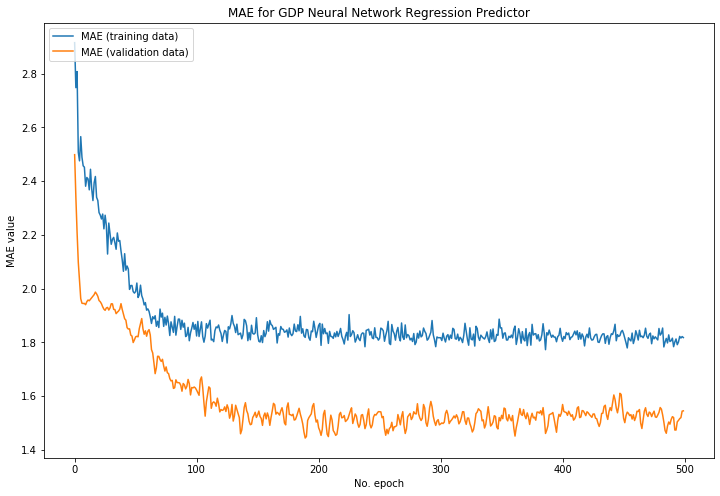

In [282]:
# Plot history: MAE
plt.plot(history_reg.history['mean_absolute_error'], label='MAE (training data)')
plt.plot(history_reg.history['val_mean_absolute_error'], label='MAE (validation data)')
plt.title('MAE for GDP Neural Network Regression Predictor')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
fig = plt.gcf()
fig.set_size_inches(12,8)
plt.show()

In [211]:
predictions_test_reg = model_reg.predict(x_test_std['TSI_PCT'])

test_mean_abs_error_reg = mean_absolute_error(y_test_rate, predictions_test_reg)
print('Test mean abs error with regularization: {0:0.2f}'.format(test_mean_abs_error_reg))

Test mean abs error with regularization: 0.69


In [212]:
training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}'.format(val_mae_history))

Training mean abs error with regularization: 1.82
Val mean abs error with regularization during training: 1.56


In [222]:
#def get_nn_model_regularization(penalty, reg_type="L2", dense_layers=16)

print('penalty=0.1, reg_type="L2", dense_layers=16')
model_reg = get_nn_model_regularization(penalty=0.1, reg_type="L2", dense_layers=16)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##########################
print('penalty=0.01, reg_type="L2", dense_layers=16')
model_reg = get_nn_model_regularization(penalty=0.01, reg_type="L2", dense_layers=16)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L2", dense_layers=16')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L2", dense_layers=16)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L1", dense_layers=16')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L1", dense_layers=16)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.01, reg_type="L1", dense_layers=16')
model_reg = get_nn_model_regularization(penalty=0.01, reg_type="L1", dense_layers=16)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L1", dense_layers=32')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L1", dense_layers=32)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L2", dense_layers=32')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L2", dense_layers=32)
model_reg.optimizer.lr = 0.005
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L2", dense_layers=32 with lr=0.001')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L2", dense_layers=32)
model_reg.optimizer.lr = 0.001
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.001, reg_type="L2", dense_layers=64 with lr=0.001')
model_reg = get_nn_model_regularization(penalty=0.001, reg_type="L2", dense_layers=64)
model_reg.optimizer.lr = 0.001
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))

##################
print('penalty=0.01, reg_type="L2", dense_layers=64 with lr=0.001')
model_reg = get_nn_model_regularization(penalty=0.01, reg_type="L2", dense_layers=64)
model_reg.optimizer.lr = 0.001
history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

training_mae_history = np.mean(history_reg.history['mean_absolute_error'])
val_mae_history = np.mean(history_reg.history['val_mean_absolute_error'])
print('Training mean abs error with regularization: {0:0.2f}'.format(training_mae_history))
print('Val mean abs error with regularization during training: {0:0.2f}\n'.format(val_mae_history))


penalty=0.1, reg_type="L2", dense_layers=16
Training mean abs error with regularization: 1.82
Val mean abs error with regularization during training: 1.55

penalty=0.01, reg_type="L2", dense_layers=16
Training mean abs error with regularization: 1.82
Val mean abs error with regularization during training: 1.58

penalty=0.001, reg_type="L2", dense_layers=16
Training mean abs error with regularization: 1.83
Val mean abs error with regularization during training: 1.57

penalty=0.001, reg_type="L1", dense_layers=16
Training mean abs error with regularization: 1.83
Val mean abs error with regularization during training: 1.54

penalty=0.01, reg_type="L1", dense_layers=16
Training mean abs error with regularization: 1.83
Val mean abs error with regularization during training: 1.53

penalty=0.001, reg_type="L1", dense_layers=32
Training mean abs error with regularization: 1.82
Val mean abs error with regularization during training: 1.53

penalty=0.001, reg_type="L2", dense_layers=32
Training m

In [320]:
#results = []
results_nonorm = pd.DataFrame(columns=['Desc','Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate', 'Training MAE Mean', 
                                'Training MAE Min', 'Val MAE Mean', 'Val MAE Min'])
for in_dense_layers in [16, 32, 64]:
    for in_reg_type in ["L1", "L2"]:
        for in_penalty in [0.1, 0.01, 0.001]:
            for in_learning_rate in [0.01, 0.001, 0.0006]:
                testcase = 'penalty={0:0.03f}, reg={1}, dense_layers={2}, lr={3:0.4f}'.format(in_penalty, in_reg_type, in_dense_layers, in_learning_rate)
                print(testcase)
                model_reg = get_nn_model_regularization(penalty=in_penalty, reg_type=in_reg_type, dense_layers=in_dense_layers)
                model_reg.optimizer.lr = in_learning_rate
                history_reg = model_reg.fit(x=x_train_std['TSI_PCT'].to_numpy(), y=y_train_rate.to_numpy(), epochs=500, validation_split=0.2, verbose=0)

                training_mae_mean = np.mean(history_reg.history['mean_absolute_error'][450:500])
                training_mae_min = np.min(history_reg.history['mean_absolute_error'])
                val_mae_mean = np.mean(history_reg.history['val_mean_absolute_error'][450:500])
                val_mae_min = np.min(history_reg.history['val_mean_absolute_error'])
                print('Training mean abs error: {0:0.2f}'.format(training_mae_mean))
                print('Val mean abs error: {0:0.2f}\n'.format(val_mae_mean))
                #results.append((testcase, training_mae_mean, training_mae_min, val_mae_mean, val_mae_min))
                results_nonorm = results_nonorm.append(pd.Series([testcase, in_penalty, in_reg_type, in_dense_layers, in_learning_rate,
                                                   training_mae_mean, training_mae_min, val_mae_mean, val_mae_min], index=results_nonorm.columns ), ignore_index=True)
                

penalty=0.100, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.81
Val mean abs error: 1.54

penalty=0.100, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.81
Val mean abs error: 1.54

penalty=0.100, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.82
Val mean abs error: 1.56

penalty=0.010, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.80
Val mean abs error: 1.51

penalty=0.010, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.80
Val mean abs error: 1.50

penalty=0.010, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.80
Val mean abs error: 1.51

penalty=0.001, reg=L1, dense_layers=16, lr=0.0100
Training mean abs error: 1.79
Val mean abs error: 1.52

penalty=0.001, reg=L1, dense_layers=16, lr=0.0010
Training mean abs error: 1.80
Val mean abs error: 1.50

penalty=0.001, reg=L1, dense_layers=16, lr=0.0006
Training mean abs error: 1.79
Val mean abs error: 1.51

penalty=0.100, reg=L2, dense_layers=16, lr=0.0

In [321]:
results

,Desc,Penalty,Reg Type,Dense Layers,Learning Rate,Training MAE Mean,Training MAE Min,Val MAE Mean,Vale MAE Min
0,"penalty=0.100, rege=L1, dense_layers=16, lr=0....",0.100,L1,16,0.0100,1.811167,1.738169,1.584313,1.427688
1,"penalty=0.100, rege=L1, dense_layers=16, lr=0....",0.100,L1,16,0.0010,1.825442,1.763919,1.518669,1.443842
2,"penalty=0.100, rege=L1, dense_layers=16, lr=0....",0.100,L1,16,0.0006,1.817069,1.750041,1.536206,1.430277
3,"penalty=0.010, rege=L1, dense_layers=16, lr=0....",0.010,L1,16,0.0100,1.809481,1.753836,1.483682,1.352947
4,"penalty=0.010, rege=L1, dense_layers=16, lr=0....",0.010,L1,16,0.0010,1.819605,1.751920,1.555147,1.468530
5,"penalty=0.010, rege=L1, dense_layers=16, lr=0....",0.010,L1,16,0.0006,1.817761,1.747402,1.504473,1.481941
6,"penalty=0.001, rege=L1, dense_layers=16, lr=0....",0.001,L1,16,0.0100,1.806707,1.730427,1.530062,1.364089
7,"penalty=0.001, rege=L1, dense_layers=16, lr=0....",0.001,L1,16,0.0010,1.796533,1.753475,1.565870,1.470016
8,"penalty=0.001, rege=L1, dense_layers=16, lr=0....",0.001,L1,16,0.0006,1.819063,1.770142,1.526176,1.477756
9,"penalty=0.100, rege=L2, dense_layers=16, lr=0....",0.100,L2,16,0.0100,1.806764,1.735461,1.531882,1.415017


In [314]:
results['Desc']

0    penalty=0.100, reg_type=L1, dense_layers=16 wi...
1    penalty=0.100, reg_type=L1, dense_layers=16 wi...
2    penalty=0.100, reg_type=L1, dense_layers=16 wi...
Name: Desc, dtype: object

In [323]:
results_nonorm.to_excel('gdp_nonorm_output_20200505.xlsx')

In [281]:
history_reg.history['mean_absolute_error']

[2.9153286406868384,
 2.7479087553526225,
 2.8077637396360697,
 2.5072290395435535,
 2.4756463326905904,
 2.5657263931475187,
 2.489201884520681,
 2.457149944807354,
 2.451993754035548,
 2.3810908731661344,
 2.4137111337561357,
 2.408237143566734,
 2.3677140286094263,
 2.444256769983392,
 2.370876902028134,
 2.3278466902281107,
 2.3942195867237293,
 2.4174124441648783,
 2.3399290787546256,
 2.3281076832821497,
 2.2831186620812667,
 2.2738928983086035,
 2.2592545120339644,
 2.2776005268096924,
 2.222543816817434,
 2.2732287080664384,
 2.235058822129902,
 2.12879741191864,
 2.244094785891081,
 2.203993747108861,
 2.16508454398105,
 2.1836846251236763,
 2.1907894611358643,
 2.1709420680999756,
 2.146562657858196,
 2.2073160347185636,
 2.1763260991949784,
 2.1791901337473014,
 2.140585409967523,
 2.1072931038705924,
 2.0645163372943274,
 2.130125873967221,
 2.068721946917082,
 2.0842119894529643,
 2.072688002335398,
 1.9971729203274375,
 2.0116106334485506,
 2.011754732382925,
 1.988992540

In [303]:
results = pd.DataFrame(columns=['Desc','Penalty', 'Reg Type', 'Dense Layers', 'Learning Rate'])

In [305]:
results.append([['test', '0', 'L1', '16', '.01']], ignore_index=True)

,0,1,2,3,4,Dense Layers,Desc,Learning Rate,Penalty,Reg Type
0,test,0,L1,16,.01,NaN,NaN,NaN,NaN,NaN


In [309]:
results

,Desc,Penalty,Reg Type,Dense Layers,Learning Rate
0,test,0,L1,16,0.01
1,test,0.02,L1,32,0.01


In [308]:
results = results.append(pd.Series(['test', 0.02, 'L1', 32, 0.01], index=results.columns ), ignore_index=True)

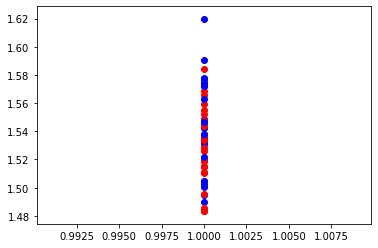

In [326]:
#scatcolors = ['red', 'blue']
for ind in results.index:
    plt.scatter(1.0, results['Val MAE Mean'][ind], c=("red" if results['Reg Type'][ind] == "L1" else "blue"))